In [1]:
import pandas as pd
import numpy as np

from pymongo import MongoClient
import os
import dotenv

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as py

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

/home/diego/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Mongo connection, extract and normalize

In [2]:
dotenv.load_dotenv()
MGURL = os.getenv("MGURL")
myclient = MongoClient(f"{MGURL}")
db = myclient.github

In [3]:
git = list(db.profiles.find({},{"_id":0, "company":0, "location":0, "email":0, "hireable":0}))

In [4]:
df = pd.json_normalize(git, "repos", ["name","repos_number","followers","created","updated"])

### Clean and prepare dataframe

In [5]:
print(df.shape)
df.head()

(1037132, 10)


repo_name  forked  stars  \
0                                      AwesomeNER   False      6   
1                     coding-interview-university    True      2   
2                            COMP2396-assignments   False      0   
3             Computer-and-Communication-Networks   False      0   
4  Costa-Rican-Household-Poverty-Level-Prediction   False      0   

           language  forks           name repos_number followers  \
0  Jupyter Notebook      2  Tarun Sudhams           23        33   
1              None      1  Tarun Sudhams           23        33   
2              Java      0  Tarun Sudhams           23        33   
3            Python      1  Tarun Sudhams           23        33   
4              HTML      4  Tarun Sudhams           23        33   

                created               updated  
0  2016-05-27T06:16:14Z  2020-05-05T07:34:00Z  
1  2016-05-27T06:16:14Z  2020-05-05T07:34:00Z  
2  2016-05-27T06:16:14Z  2020-05-05T07:34:00Z  
3  2016-05-27T06:16:14Z  2020-05-05T07:34:00Z  
4  2016-05-27T06:16:14Z  2020-05-05T07:34:00Z

In [6]:
df.created = df.created.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.updated = df.updated.str.replace(r"\b(?:(?!\d{4}-\d{2}).*)","")
df.drop(columns={"repo_name", "language"}, inplace=True)

In [7]:
df.isnull().sum()

forked              0
stars               0
forks               0
name            33898
repos_number        0
followers           0
created             0
updated             0
dtype: int64

In [8]:
df["years"] = df.updated.astype(int)-df.created.astype(int)
df.drop(columns={"created","updated"}, axis=1, inplace=True)
df.dropna(how="any", inplace=True)

In [9]:
print(df.shape)
df.isnull().sum()

(1003234, 7)


forked          0
stars           0
forks           0
name            0
repos_number    0
followers       0
years           0
dtype: int64

In [10]:
num = df.groupby(["name", "repos_number", "followers", "years"]).agg({"stars":"sum", "forks":"sum"}).reset_index()

In [11]:
num[num.name=="Tarun Sudhams"]

name  repos_number  followers  years  stars  forks
33492  Tarun Sudhams            23         33      4     49     38

In [12]:
cat = df.groupby(["name","forked"]).size().unstack(fill_value=0).reset_index().rename(columns={"index":"name",False:"user_repo",True:"forked_repo"})

In [13]:
cat[cat.name=="Tarun Sudhams"]

forked           name  user_repo  forked_repo
32038   Tarun Sudhams         19            4

In [14]:
df = pd.merge(num, cat, on="name")

In [15]:
df[df.name=="Tarun Sudhams"]

name  repos_number  followers  years  stars  forks  user_repo  \
33492  Tarun Sudhams            23         33      4     49     38         19   

       forked_repo  
33492            4

### Descriptive Analysis

In [16]:
print(df.shape)
df.head()

(41335, 8)


name  repos_number  followers  years  stars  forks  \
0   Aníbal Catheringer             2          1      6      0      0   
1                Cohen            18          2      3      0      2   
2     Enrico Antonello            43         14      7      7      2   
3         Jakub Smadiš            16          1      3      0      0   
4         Marián Černý            16          3      8     22      6   

   user_repo  forked_repo  
0          2            0  
1         18            0  
2         28           15  
3          3           13  
4          3           13

In [17]:
df.describe()

repos_number     followers         years          stars         forks  \
count  41335.000000  41335.000000  41335.000000   41335.000000  41335.000000   
mean      24.288521     23.928680      6.178275      76.527979     20.784081   
std      105.041222    339.126622      2.887503     998.011995    290.819093   
min        1.000000      0.000000      0.000000       0.000000      0.000000   
25%        5.000000      3.000000      4.000000       0.000000      0.000000   
50%       12.000000      6.000000      6.000000       3.000000      1.000000   
75%       27.000000     13.000000      8.000000      14.000000      6.000000   
max    14637.000000  57545.000000     12.000000  123102.000000  34154.000000   

          user_repo   forked_repo  
count  41335.000000  41335.000000  
mean      15.033410     16.244345  
std       53.370244    103.753181  
min        0.000000      0.000000  
25%        3.000000      1.000000  
50%        7.000000      4.000000  
75%       16.000000     12.000000  
max     9349.000000  14433.000000

In [18]:
X = df.drop(columns={"name"})

In [19]:
#we can observe a lot of rows with at least 1 column > 1k. Mainly stars and forks, while any mean is higher than 400
outliers = df[(X>1000).any(1)]
print(outliers.shape)
outliers.head()

(549, 8)


name  repos_number  followers  years  stars  forks  \
361    Adam Coddington           185        174     10   1975    434   
421        Adam Mckaig           141        358     12   2029    461   
467      Adam Zapletal            31         72     11   1987    376   
1080      Alberto Paro           122        129     12   1108    401   
1083  Alberto Pettarin            49         72      7   1071    271   

      user_repo  forked_repo  
361         120           65  
421          82           59  
467          10           21  
1080         30           92  
1083         29           20

<function matplotlib.pyplot.show(*args, **kw)>

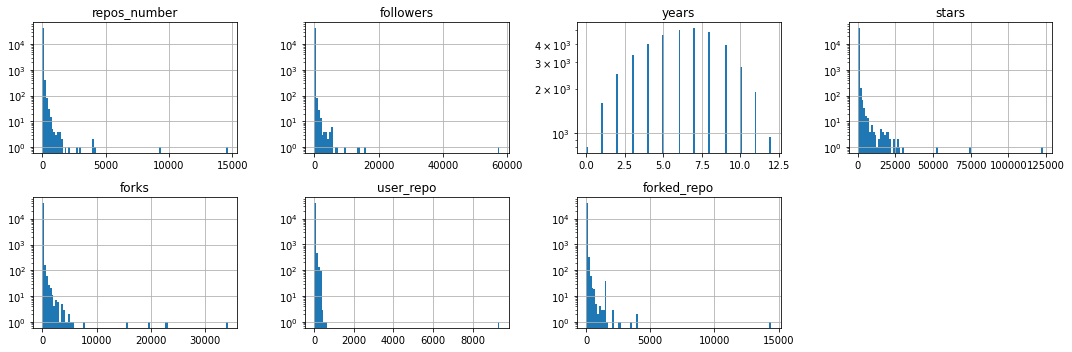

In [20]:
#we can see in all variables except for years and stars that the frequency of 0 es huge
figure = plt.figure(figsize=(15,5))

for n, c in enumerate(X.columns):
  ax = figure.add_subplot(2,4,n+1)
  ax.set_title(c)
  ax.set_yscale("log") #the log scale help us to have a better idea of our data when the distribution is not fair
  X[c].hist(ax=ax, bins=100)

figure.tight_layout() #this feature separate the graphs correctly
plt.show

Text(0.5, 1.0, 'Correlation matrix')

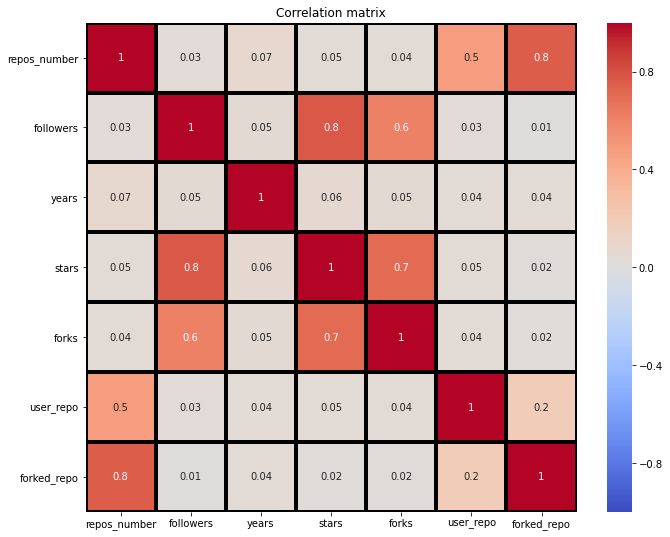

In [21]:
plt.figure(figsize=(11,9))

sns.heatmap(X.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm' , linewidths=3, linecolor='black')

plt.title('Correlation matrix')

#### There is a big positive linear relation between followers, stars and forks. However none of the repo columns  neither yeas are related with the 3 previous vars. Therefore we will take these 3 vars as the main characteristics to determine the seniority of users

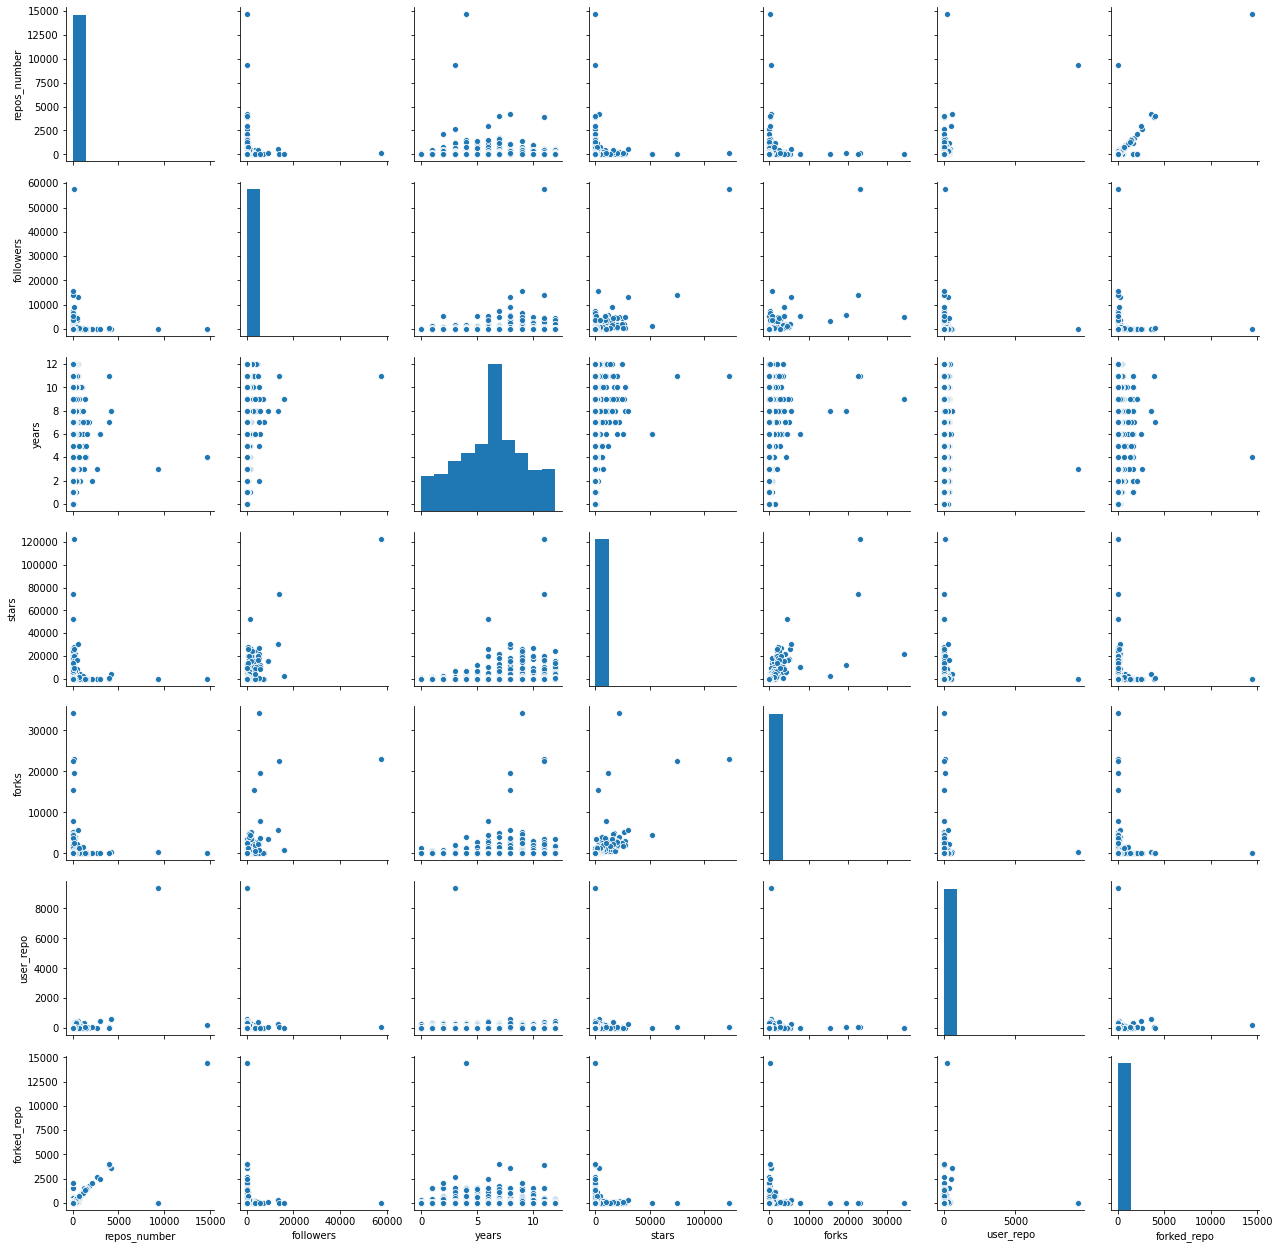

In [22]:
sns.pairplot(X)

#### Above we can see some columns with really huge outliers that could affect our cluster model. Therefore we will apply the Standard Scaler to eliminate them, which will be useful for the PCA reduction

In [23]:
#we will exclude the id and the repos_number as we will use the user_repo and forked_repo for clustering
name = df.name
repos = df.repos_number
X = df.drop(columns={"name","repos_number"})

### Scale

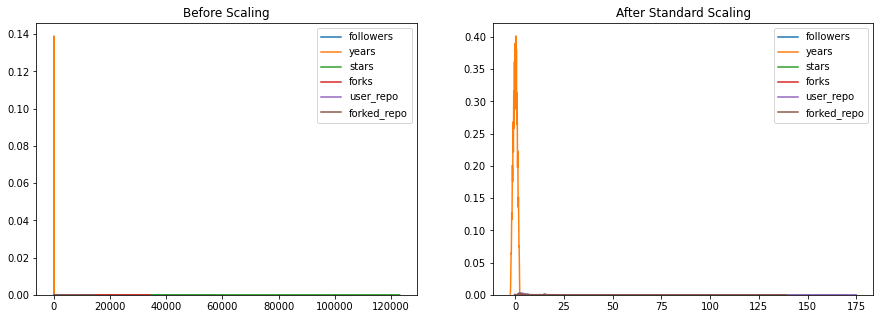

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

strans = scaler.fit_transform(X)

X_SS = pd.DataFrame(strans)
X_SS.columns = X.columns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.set_title('Before Scaling')
for e in X.columns:
    sns.kdeplot(X[e], ax=ax1, legend=True)
ax2.set_title('After Standard Scaling')
for e in X_SS.columns:
    sns.kdeplot(X_SS[e], ax=ax2, legend=True)
plt.show()

#### We show it again

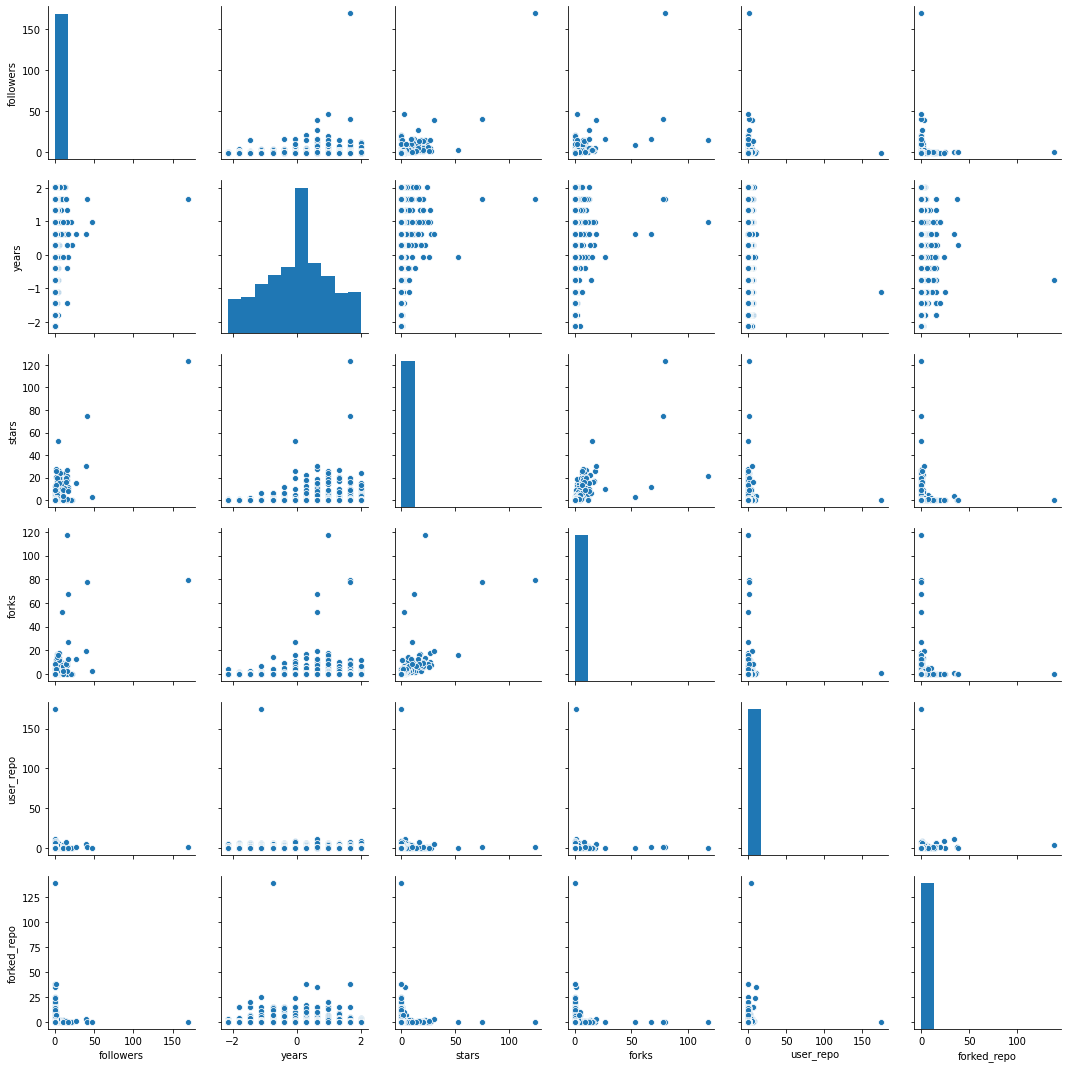

In [25]:
sns.pairplot(X_SS)

#### Before impletementing the PCA dimensionality reduction lets check the dimensions

/home/diego/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning:

Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.



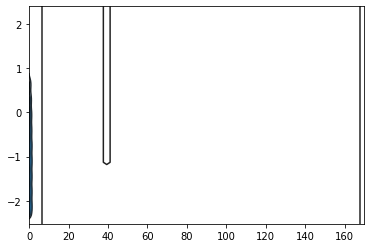

In [26]:
sns.kdeplot(X_SS)

#### Seems to be more than 3 

In [27]:
X_SS.shape

(41335, 6)

#### 6 dimensions actually

### PCA -- Choosing number of components

In [28]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_SS)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [29]:
pca.explained_variance_ratio_

array([0.40140565, 0.20026292, 0.1632997 , 0.13448881, 0.06655205,
       0.03399088])

Text(0, 0.5, 'Cummulative Explained Variance')

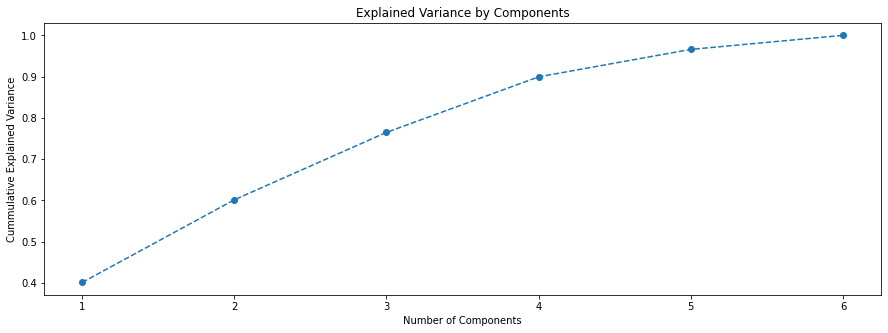

In [30]:
plt.figure(figsize=(15,5)) 
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--")
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cummulative Explained Variance")

#### The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80 % of the variance. So, in this instance, we decide to keep 3 components.

In [31]:
pca = PCA(n_components=3).fit(X_SS)
X_3d = pca.transform(X_SS)

In [32]:
X_3d.shape

(41335, 3)

In [33]:
pca.components_

array([[ 0.57359547,  0.07171377,  0.59796979,  0.55161715,  0.05559262,
         0.03009108],
       [-0.05129609,  0.24161356, -0.03999266, -0.04077377,  0.67987538,
         0.68811275],
       [ 0.03640513, -0.96760606,  0.0270922 ,  0.03116058,  0.1821904 ,
         0.16587606]])

In [34]:
pca.explained_variance_ratio_

array([0.40140565, 0.20026292, 0.1632997 ])

### Silhouette Score

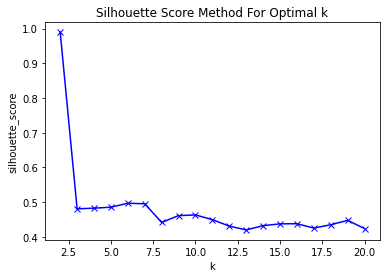

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [35]:
#we use the silhouette method to determine the ideal number of clusters. Although our clusters objective is 4-7
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = []
kmax = 20
klusters = range(2, kmax+1)
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in klusters:
    km = KMeans(n_clusters = k).fit(X_3d)
    labels = km.labels_
    sil.append(silhouette_score(X_3d, labels, metric = 'euclidean'))
    
plt.plot(klusters, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Score Method For Optimal k')
plt.show()
%time

- Standard Scaler --> Optimal Clusters 2

#### The optimal number of clusters is 2, but we want between 5-7 so we will start with 7, see how it goes and maybe we will exclude outliers

In [36]:
model = KMeans(n_clusters=7)

labels = model.fit_predict(X_3d)

In [37]:
df_pca_kmeans = pd.concat([df, pd.DataFrame(X_3d).rename(columns={0:"Component1", 1:"Component2", 2:"Component3"})], axis=1)
df_pca_kmeans["label"] = labels
df_pca_kmeans.head()

name  repos_number  followers  years  stars  forks  \
0   Aníbal Catheringer             2          1      6      0      0   
1                Cohen            18          2      3      0      2   
2     Enrico Antonello            43         14      7      7      2   
3         Jakub Smadiš            16          1      3      0      0   
4         Marián Černý            16          3      8     22      6   

   user_repo  forked_repo  Component1  Component2  Component3  label  
0          2            0   -0.146773   -0.279238   -0.017489      0  
1         18            0   -0.199131   -0.326876    1.042769      0  
2         28           15   -0.060528    0.232609   -0.238055      2  
3          3           13   -0.216470   -0.431309    1.012025      0  
4          3           13   -0.064344   -0.014952   -0.662047      2

### 3D Graphs
I ll do it in matplotlib and interactive in plotly to have both versions

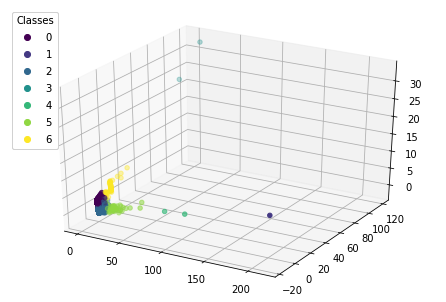

In [38]:
x = df_pca_kmeans.Component1
y = df_pca_kmeans.Component2
z = df_pca_kmeans.Component3

fig = plt.figure()
ax = Axes3D(fig)

scatter = ax.scatter(x, y, z, c=df_pca_kmeans.label)

legend = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")

ax.add_artist(legend)
plt.show()

In [39]:
clust = df_pca_kmeans.iloc[:,8:]

In [46]:
cont = []
for i in range(7):
    fig = go.Scatter3d(x=clust.Component1[clust.label==i],
                        y=clust.Component2[clust.label==i],
                        z=clust.Component3[clust.label==i],
                        marker=dict(opacity=0.9,
                                    reversescale=True,
                                    colorscale='Blues',
                                    size=5),
                        line=dict (width=0.02),
                        mode='markers')

    cont.append(fig)    
    
#Make Plot.ly Layout
mylayout = go.Layout(scene=dict(xaxis=dict( title="PCA1"),
                                yaxis=dict( title="PCA2"),
                                zaxis=dict(title="PCA3")),)

#Plot and save html

py.iplot({"data": cont,
                     "layout": mylayout},
                     filename=("3DPlot.html"))

<img src='../OUTPUT/radar.png'/>

In [47]:
lab = df_pca_kmeans.label.value_counts()
lab

0    21632
2    19589
6       57
5       52
4        2
3        2
1        1
Name: label, dtype: int64

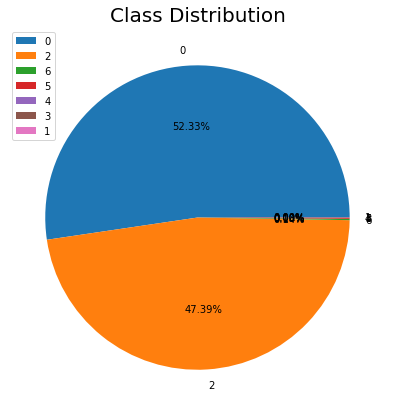

In [48]:
plt.rcParams['figure.figsize'] = (15, 7)
plt.pie(lab, labels = lab.keys(), autopct = '%.2f%%')
plt.title('Class Distribution', fontsize = 20)
plt.axis('off')
plt.legend(loc=2)
plt.show()

#### We can clearly see the 7 classes in the 3D graphs, however the distribution of the classes is really unfair to obtain clearly programmers by seniority. However we are going to see how each class is identified in each variable

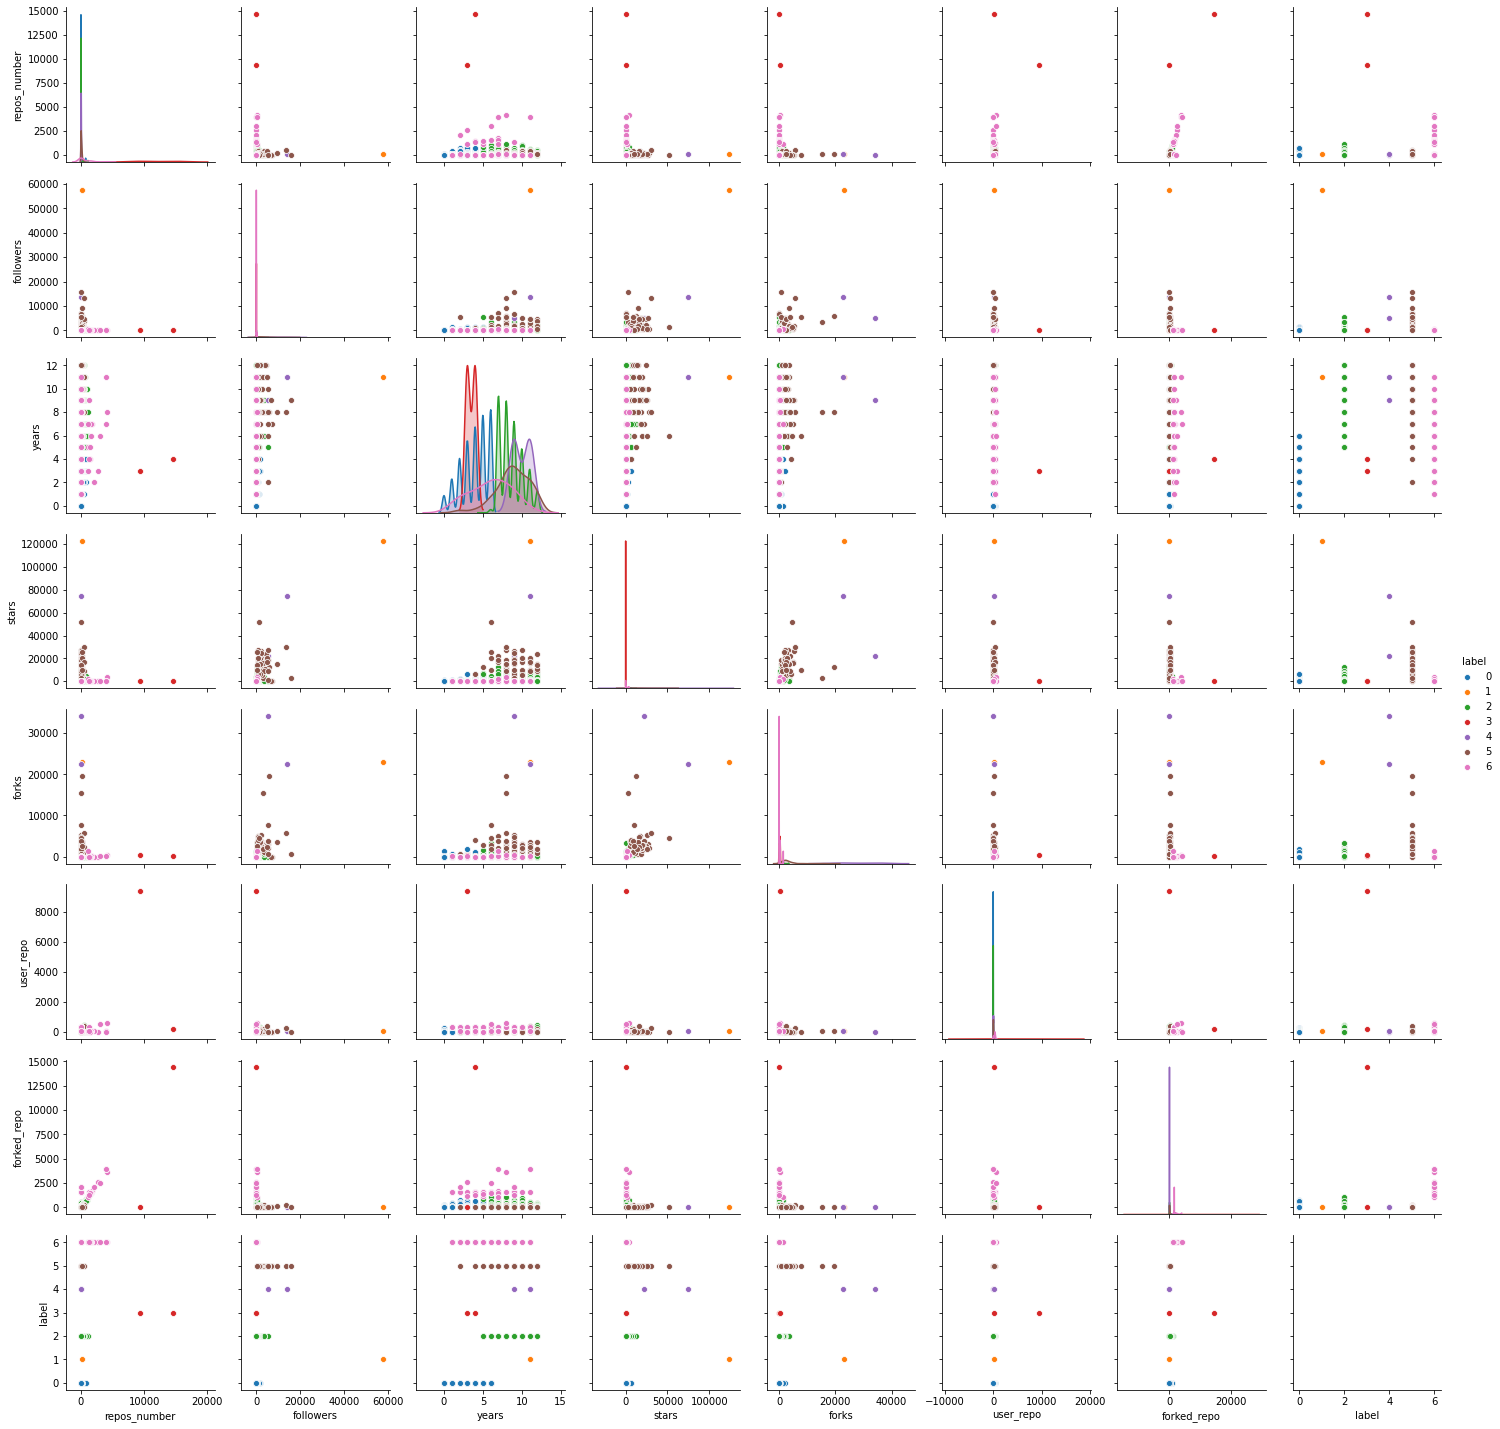

In [49]:
import warnings
warnings.filterwarnings("ignore")

sns.pairplot(df_pca_kmeans.iloc[:,[1,2,3,4,5,6,7,11]], hue="label")
plt.show()

### Conlusions from the graph:
- Forked_repos: the label 6 is clearly differentiated from the others
- Stars: label 1 is crearly differentiated and almost all user in the label 5
- Years: labels 0 and 2 are differentiated
- Repos_number: label 3 is differentiated

In [50]:
df_pca_kmeans.describe()

repos_number     followers         years          stars         forks  \
count  41335.000000  41335.000000  41335.000000   41335.000000  41335.000000   
mean      24.288521     23.928680      6.178275      76.527979     20.784081   
std      105.041222    339.126622      2.887503     998.011995    290.819093   
min        1.000000      0.000000      0.000000       0.000000      0.000000   
25%        5.000000      3.000000      4.000000       0.000000      0.000000   
50%       12.000000      6.000000      6.000000       3.000000      1.000000   
75%       27.000000     13.000000      8.000000      14.000000      6.000000   
max    14637.000000  57545.000000     12.000000  123102.000000  34154.000000   

          user_repo   forked_repo    Component1    Component2    Component3  \
count  41335.000000  41335.000000  4.133500e+04  4.133500e+04  4.133500e+04   
mean      15.033410     16.244345 -4.809030e-17  1.126956e-16  3.172066e-18   
std       53.370244    103.753181  1.551932e+00  1.096178e+00  9.898595e-01   
min        0.000000      0.000000 -2.992753e-01 -1.547162e+01 -2.033135e+00   
25%        3.000000      1.000000 -1.688588e-01 -3.381623e-01 -6.781079e-01   
50%        7.000000      4.000000 -9.848591e-02 -1.050380e-01 -5.404646e-03   
75%       16.000000     12.000000 -2.080239e-02  1.526065e-01  6.823049e-01   
max     9349.000000  14433.000000  2.149379e+02  1.184941e+02  3.293189e+01   

              label  
count  41335.000000  
mean       0.962743  
std        1.025237  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        2.000000  
max        6.000000

In [51]:
#this allows us to see all the columns
pd.set_option('display.max_columns', None)

df_pca_kmeans.groupby("label").describe()

repos_number                                                       \
             count          mean          std     min      25%      50%   
label                                                                     
0          21632.0     16.169841    28.744650     1.0      3.0      9.0   
1              1.0    102.000000          NaN   102.0    102.0    102.0   
2          19589.0     29.950942    47.095516     1.0      7.0     17.0   
3              2.0  11993.000000  3739.180659  9349.0  10671.0  11993.0   
4              2.0     36.000000    38.183766     9.0     22.5     36.0   
5             52.0    118.826923   123.892382     1.0     38.0     65.0   
6             57.0    651.438596  1106.286081     1.0      7.0     22.0   

                        followers                                      \
           75%      max     count          mean          std      min   
label                                                                   
0         19.0    756.0   21632.0      9.276766    32.213882      0.0   
1        102.0    102.0       1.0  57545.000000          NaN  57545.0   
2         35.0   1107.0   19589.0     27.917301   101.291155      0.0   
3      13315.0  14637.0       2.0     13.500000    19.091883      0.0   
4         49.5     63.0       2.0   9476.000000  6161.728491   5119.0   
5        156.0    561.0      52.0   3146.134615  3108.650726    251.0   
6       1240.0   4196.0      57.0     24.947368    65.685512      0.0   

                                               years                       \
            25%      50%       75%      max    count       mean       std   
label                                                                       
0          2.00      4.0      9.00   1522.0  21632.0   3.897282  1.721244   
1      57545.00  57545.0  57545.00  57545.0      1.0  11.000000       NaN   
2          4.00      9.0     19.00   5418.0  19589.0   8.690234  1.487377   
3          6.75     13.5     20.25     27.0      2.0   3.500000  0.707107   
4       7297.50   9476.0  11654.50  13833.0      2.0  10.000000  1.414214   
5        976.75   2005.5   4552.75  15832.0     52.0   8.846154  2.145534   
6          3.00      6.0     18.00    415.0     57.0   6.000000  2.598076   

                                         stars                               \
        min    25%   50%    75%   max    count           mean           std   
label                                                                         
0       0.0   3.00   4.0   5.00   6.0  21632.0      19.448317    133.282544   
1      11.0  11.00  11.0  11.00  11.0      1.0  123102.000000           NaN   
2       5.0   7.00   8.0  10.00  12.0  19589.0      88.021390    416.913414   
3       3.0   3.25   3.5   3.75   4.0      2.0      53.000000      7.071068   
4       9.0   9.50  10.0  10.50  11.0      2.0   48169.500000  37419.383754   
5       2.0   8.00   9.0  10.25  12.0     52.0   15222.903846   9073.429555   
6       1.0   4.00   6.0   8.00  11.0     57.0     126.122807    569.157086   

                                                             forks  \
            min        25%       50%        75%       max    count   
label                                                                
0           0.0       0.00       1.0       6.00    6693.0  21632.0   
1      123102.0  123102.00  123102.0  123102.00  123102.0      1.0   
2           0.0       1.00       6.0      30.00   12774.0  19589.0   
3          48.0      50.50      53.0      55.50      58.0      2.0   
4       21710.0   34939.75   48169.5   61399.25   74629.0      2.0   
5          27.0    9642.00   15252.5   19704.50   52132.0     52.0   
6           0.0       0.00       6.0      26.00    3854.0     57.0   

                                                                        \
               mean          std      min       25%      50%       75%   
label                                                                    
0          6.295766    34.379428      0

#### As we can see from the previous graphs and the descriptive tables, the clusters could be taken as valid, however, 3/7 labels have 5 users in total (out of 50k), which is not a good final clustering, so we should repeat the process, eliminating outliers until we have well distributed samples

#### However, before deleting the outliers, we are going to see the characteristics of each class in a radar chart. To do so, as we have a many scales, and a radar chart needs the vars to have the same scale, we will normalize our dataset and group by label, obtaining the mean of each variable as the measure indicator

In [52]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

X2 = df_pca_kmeans.iloc[:,1:8]

mtrans = minmax.fit_transform(X2)

X_MM = pd.DataFrame(mtrans)

X_MM.columns = X2.columns

X_MM["label"] = labels

In [53]:
X_norm = X_MM.groupby("label").agg({"repos_number":"mean", "followers":"mean", "years":"mean", "stars":"mean", "forks":"mean", "user_repo":"mean", "forked_repo":"mean"}).reset_index()
X_norm

label  repos_number  followers     years     stars     forks  user_repo  \
0      0      0.001036   0.000161  0.324773  0.000158  0.000184   0.001298   
1      1      0.006901   1.000000  0.916667  1.000000  0.675616   0.010696   
2      2      0.001978   0.000485  0.724186  0.000715  0.000711   0.001804   
3      3      0.819350   0.000235  0.291667  0.000431  0.005256   0.510910   
4      4      0.002391   0.164671  0.833333  0.391297  0.830005   0.003637   
5      5      0.008050   0.054673  0.737179  0.123661  0.092600   0.007282   
6      6      0.044441   0.000434  0.500000  0.001025  0.001527   0.028512   

   forked_repo  
0     0.000640  
1     0.000139  
2     0.001261  
3     0.500000  
4     0.000139  
5     0.003528  
6     0.119070

In [55]:
categories = list(X_MM)

fig = go.Figure()

for v in X_norm.values:
    fig.add_trace(go.Scatterpolar(
    r=v[1:],
    theta=categories,
    fill="toself",
    name=str(v[0]),
    text=str(v[0]),
    opacity=1,
    marker=dict(size=10)
    ))
    
fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 1])), showlegend=True)

fig.show()

<img src='../OUTPUT/radar.png'/>

#### This chart allows us to see the characteristics of each class based in the initial variables, but in a scaled way. Therefore it allows us to identificate clearly 7 type of users

In [56]:
df_pca_kmeans.groupby("label").agg({"repos_number":"mean", "followers":"mean", "years":"mean", "stars":"mean", "forks":"mean", "user_repo":"mean", "forked_repo":"mean"})

repos_number     followers      years          stars         forks  \
label                                                                       
0         16.169841      9.276766   3.897282      19.448317      6.295766   
1        102.000000  57545.000000  11.000000  123102.000000  23075.000000   
2         29.950942     27.917301   8.690234      88.021390     24.266629   
3      11993.000000     13.500000   3.500000      53.000000    179.500000   
4         36.000000   9476.000000  10.000000   48169.500000  28348.000000   
5        118.826923   3146.134615   8.846154   15222.903846   3162.673077   
6        651.438596     24.947368   6.000000     126.122807     52.140351   

         user_repo  forked_repo  
label                            
0        12.135124     9.241402  
1       100.000000     2.000000  
2        16.868855    18.199296  
3      4776.500000  7216.500000  
4        34.000000     2.000000  
5        68.076923    50.923077  
6       266.561404  1718.543860

#### As said before, this notebook is useful to see the application of PCA and K Means in a dataset with the purpose of finding clusters. However for a real utility, the outliers must be excluded to have well distributed clusters. Therefore I will do a similar notebook without outliers